In [3]:
## This notebook is an investigation of different data sets/data types with regards to 
## Monitoring Living Shorelines

In [3]:
## Importing Libraries 
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [8]:
# Read a shapefile of NYC's shoreline. This data set was retrieved from (Insert Link)

local_path = "C:/Users/kargued000" #This is where the copy of the remote repository was cloned onto the local computer(varies from user to user)
repo_path = "/Living_Shorelines/data/nyc_gov_shoreline/nyc_shoreline.shp" #this is the structure of the repository(will always be the same)

nyc_shoreline = gpd.read_file(local_path + repo_path) # reading the data and storing it as a geopandas dataframe 

<Axes: >

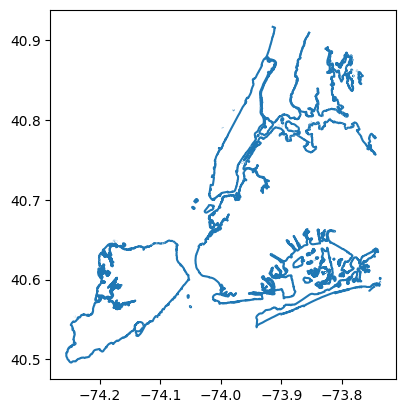

In [9]:
# creating a simple plot of the geopandas dataframe 
nyc_shoreline.plot()

In [77]:
##importing data from census to look at census tracts 
## https://www.nyc.gov/site/planning/data-maps/open-data.page#census
file_path = "/Users/kenneth/Downloads/nyct2020_23b/nyct2020.shp"
nyc_census_tracts = gpd.read_file(file_path)

<AxesSubplot:>

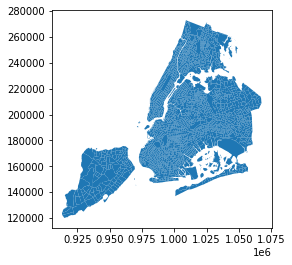

In [79]:
## plotting the entire map 
nyc_census_tracts.plot()

In [102]:
## creating a mask that marks the row as true if the value in the boro name column is manhattan
mask = nyc_census_tracts['BoroName'] == 'Manhattan'

In [103]:
##applying the mask onto the entire dataframe-- this will select only the manhattan rows
manhattan = nyc_census_tracts.loc[mask]

In [106]:
##plotting the census tracts 
manhattan.head()

,CTLabel,BoroCode,BoroName,CT2020,BoroCT2020,CDEligibil,NTAName,NTA2020,CDTA2020,CDTANAME,GEOID,PUMA,Shape_Leng,Shape_Area,geometry
0,1,1,Manhattan,000100,1000100,NaN,The Battery-Governors Island-Ellis Island-Libe...,MN0191,MN01,MN01 Financial District-Tribeca (CD 1 Equivalent),36061000100,4121,10833.043929,1.843005e+06,"MULTIPOLYGON (((972081.788 190733.467, 972184...."
1,2.01,1,Manhattan,000201,1000201,NaN,Chinatown-Two Bridges,MN0301,MN03,MN03 Lower East Side-Chinatown (CD 3 Equivalent),36061000201,4103,4754.495247,9.723121e+05,"POLYGON ((988548.218 197770.375, 987978.808 19..."
2,6,1,Manhattan,000600,1000600,NaN,Chinatown-Two Bridges,MN0301,MN03,MN03 Lower East Side-Chinatown (CD 3 Equivalent),36061000600,4103,6976.286215,2.582705e+06,"POLYGON ((986961.185 199553.643, 987206.139 19..."
3,14.01,1,Manhattan,001401,1001401,NaN,Lower East Side,MN0302,MN03,MN03 Lower East Side-Chinatown (CD 3 Equivalent),36061001401,4103,5075.332000,1.006117e+06,"POLYGON ((987475.016 200297.218, 987705.443 20..."
4,14.02,1,Manhattan,001402,1001402,NaN,Lower East Side,MN0302,MN03,MN03 Lower East Side-Chinatown (CD 3 Equivalent),36061001402,4103,4459.156019,1.226206e+06,"POLYGON ((988387.669 201258.312, 988621.002 20..."


In [ ]:
## Importing data from American Community Survey for Per Capita Income(future work, left on 07/10/23)
## https://www.nyc.gov/site/planning/data-maps/open-data/districts-download-metadata.page